In [3]:
from sklearn.ensemble import RandomForestRegressor
from flask_ood.datasets.SMILESDataset import (
    IIDDensityDataset,
    OODDensityDataset,
    TrainDensityDataset,
    IIDHoFDataset,
    OODHoFDataset,
    TrainHoFDataset,
    TrainQM9_alphaDataset,
    IIDQM9_alphaDataset,
    OODQM9_alphaDataset,
    TrainQM9_gapDataset,
    IIDQM9_gapDataset,
    OODQM9_gapDataset,
    TrainQM9_cvDataset,
    IIDQM9_cvDataset,
    OODQM9_cvDataset,
    TrainQM9_g298Dataset,
    IIDQM9_g298Dataset,
    OODQM9_g298Dataset,
    TrainQM9_h298Dataset,
    IIDQM9_h298Dataset,
    OODQM9_h298Dataset,
    TrainQM9_homoDataset,
    IIDQM9_homoDataset,
    OODQM9_homoDataset,
    TrainQM9_lumoDataset,
    IIDQM9_lumoDataset,
    OODQM9_lumoDataset,
    TrainQM9_muDataset,
    IIDQM9_muDataset,
    OODQM9_muDataset,
    TrainQM9_r2Dataset,
    IIDQM9_r2Dataset,
    OODQM9_r2Dataset,
    TrainQM9_zpveDataset,
    IIDQM9_zpveDataset,
    OODQM9_zpveDataset
)
import numpy as np
import os
import pickle
from flask_ood.viz.ParityPlot import DensityOODParityPlot, HoFOODParityPlot, GapOODParityPlot, AlphaOODParityPlot, CvOODParityPlot, G298OODParityPlot
from flask_ood.viz.ParityPlot import H298OODParityPlot, HomoOODParityPlot, LumoOODParityPlot, MuOODParityPlot, R2OODParityPlot, ZpveOODParityPlot
from dataset import dataset_wrapper, denormalize_target

def run_experiment(train_dataset, iid_test_dataset, ood_test_dataset, target, num_epochs=5):
    """
    Runs the experiment.
    """
    model = RandomForestRegressor(n_estimators=500,
                                  max_features='sqrt',
                                  n_jobs=-1,
                                  verbose=0)
    train_features, train_y = dataset_wrapper(train_dataset, train_dataset)
    model.fit(train_features, train_y)  

    train_y_pred = model.predict(train_features)
    train_y_pred = denormalize_target(train_y_pred, train_dataset)
    train_y = denormalize_target(train_y, train_dataset)
    mean_score = np.mean(np.abs(train_y - train_y_pred))
    std_score = np.std(np.abs(train_y - train_y_pred))

    iid_features, iid_y = dataset_wrapper(iid_test_dataset, train_dataset)
    ood_features, ood_y = dataset_wrapper(ood_test_dataset, train_dataset)

    iid_preds = model.predict(iid_features)
    ood_preds = model.predict(ood_features)

    iid_preds = denormalize_target(iid_preds, train_dataset)
    ood_preds = denormalize_target(ood_preds, train_dataset)
    iid_real_vals = denormalize_target(iid_y, train_dataset)
    ood_real_vals = denormalize_target(ood_y, train_dataset)

    iid_smiles = [smiles for smiles, _ in iid_test_dataset]
    ood_smiles = [smiles for smiles, _ in ood_test_dataset]
    test_results = {
        "target": target,  # "Density", "HoF", or "gap"
        "mean_score": mean_score,
        "std_score": std_score,
        "iid_smiles": iid_smiles,
        "pred_iid_vals": iid_preds,
        "real_iid_vals": iid_real_vals,
        "ood_smiles": ood_smiles,
        "pred_ood_vals": ood_preds,
        "real_ood_vals": ood_real_vals,
    }
    #Save the model (optional)
    #os.makedirs(f'./results/{target}',exist_ok=True)
    #with open(f"./results/{target}/model.pkl",'wb') as f:
    #    pickle.dump(model,f)
    return test_results

def process_results(results, plotter):
    """
    Processes the results.
    """

    target = results["target"]
    pred_iid_vals = np.array(results["pred_iid_vals"])
    real_iid_vals = np.array(results["real_iid_vals"])
    pred_ood_vals = np.array(results["pred_ood_vals"])
    real_ood_vals = np.array(results["real_ood_vals"])
    os.makedirs(f'./results/{target}',exist_ok=True)
    
    np.save(f"./results/{target}/{target}_iid_preds.npy", pred_iid_vals)
    np.save(f"./results/{target}/{target}_iid_real.npy", real_iid_vals)
    np.save(f"./results/{target}/{target}_ood_preds.npy", pred_ood_vals)
    np.save(f"./results/{target}/{target}_ood_real.npy", real_ood_vals)


    true_labels = {
        "iid": real_iid_vals,
        "ood": real_ood_vals,
    }

    fake_labels = {
        "iid": pred_iid_vals,
        "ood": pred_ood_vals,
    }

    fig = plotter(true_labels, fake_labels, title=target, model_name="Random Forest")
    fig.savefig(f"./results/{target}/{target}_parity_plot.png")

def plot_results(target,plotter):
    """
    Reproduce plot only with pre-existing results.
    """
    assert target in [
        "density",
        "hof",
        "alpha",
        "cv",
        "gap",
        "homo",
        "lumo",
        "mu",
        "r2",
        "zpve"
    ], "target_value must be either 'density', 'hof', 'alpha','cv', 'gap', 'homo', 'lumo', 'mu', 'r2', or 'zpve'. 'g298', 'h298', 'u0' and 'u298' are currently not supported."
    pred_iid_vals=np.load(f"./results/{target}/{target}_iid_preds.npy")
    real_iid_vals=np.load(f"./results/{target}/{target}_iid_real.npy")
    pred_ood_vals=np.load(f"./results/{target}/{target}_ood_preds.npy")
    real_ood_vals=np.load(f"./results/{target}/{target}_ood_real.npy")
    
    true_labels = {
        "iid": real_iid_vals,
        "ood": real_ood_vals,
    }

    fake_labels = {
        "iid": pred_iid_vals,
        "ood": pred_ood_vals,
    }
    fig = plotter(true_labels, fake_labels, title=target, model_name="Random Forest")
    fig.savefig(f"./results/{target}/{target}_parity_plot.png")
    
def main():
    #train_dataset = TrainDensityDataset()
    #iid_test_dataset = IIDDensityDataset()
    #ood_test_dataset = OODDensityDataset()
    #results = run_experiment(
    #    train_dataset, iid_test_dataset, ood_test_dataset, "Density", num_epochs=5
    #)
    #process_results(results, DensityOODParityPlot)
    #print('Done Density')
    
    #train_dataset = TrainHoFDataset()
    #iid_test_dataset = IIDHoFDataset()
    #ood_test_dataset = OODHoFDataset()

    #results = run_experiment(train_dataset,
    #                         iid_test_dataset,
    #                         ood_test_dataset,
    #                         "HoF",
    #                         num_epochs=5)
    #process_results(results, HoFOODParityPlot)
    #print('Done HoF')
    
    #Update to include QM9 Dataset of Interest
    train_dataset=TrainQM9_zpveDataset()
    iid_test_dataset=IIDQM9_zpveDataset()
    ood_test_dataset=OODQM9_zpveDataset()
    results = run_experiment(
        train_dataset, iid_test_dataset, ood_test_dataset, "zpve", num_epochs=5
    )
    process_results(results, ZpveOODParityPlot)
    print('Done zpve')

(117692, 203)
(6110, 203)
(10000, 203)
Done zpve


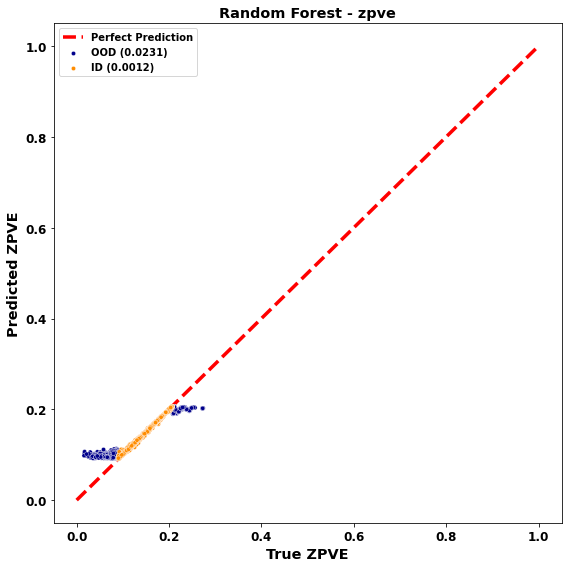

In [7]:
main()